In [63]:
# library

import pandas as pd
import numpy as np
import joblib
import datetime as dt
from datetime import date 
from datetime import datetime
import awswrangler as wr

import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from re import search
import re

import pickle 
import warnings 

In [64]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

sns.set(rc={'figure.figsize':(18,6)})

In [65]:
#read the dataset

df_raw = pd.read_excel('/Users/user/python_dataset/online_retail.xlsx')

In [66]:
df_raw.tail()

,InvoiceNo,StockCode,lower,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,NaN,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.8500,12680.0000,France
541905,581587,22899,NaN,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.1000,12680.0000,France
541906,581587,23254,NaN,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.1500,12680.0000,France
541907,581587,23255,NaN,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.1500,12680.0000,France
541908,581587,22138,NaN,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.9500,12680.0000,France


In [67]:
df_raw.groupby('Country')['CustomerID'].nunique().head()

Country
Australia     9
Austria      11
Bahrain       2
Belgium      25
Brazil        1
Name: CustomerID, dtype: int64

In [68]:
df_raw['Amount'] = df_raw['Quantity'] * df_raw['UnitPrice']
df_raw.head()

,InvoiceNo,StockCode,lower,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,white hanging heart t-light holder,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom,15.3000
1,536365,71053,white metal lantern,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,20.3400
2,536365,84406B,cream cupid hearts coat hanger,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom,22.0000
3,536365,84029G,knitted union flag hot water bottle,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,20.3400
4,536365,84029E,red woolly hottie white heart.,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,20.3400


In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   lower        1816 non-null    object        
 3   Description  540455 non-null  object        
 4   Quantity     541909 non-null  int64         
 5   InvoiceDate  541909 non-null  datetime64[ns]
 6   UnitPrice    541909 non-null  float64       
 7   CustomerID   406829 non-null  float64       
 8   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 37.2+ MB


In [72]:
df_raw['CustomerID'].fillna(df_raw['Country'].map(str)+ '-' + df_raw['Description'].map(str), inplace = True)

In [73]:
df_raw.isnull().sum()

InvoiceNo           0
StockCode           0
lower          540093
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID          0
Country             0
Amount              0
dtype: int64

In [75]:
# From dataframe we know that calceled order because UnitPrice and Amount = 0
df_raw[pd.isnull(df_raw['Description'])]

,InvoiceNo,StockCode,lower,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
622,536414,22139,NaN,NaN,56,2010-12-01 11:52:00,0.0000,United Kingdom-nan,United Kingdom,0.0000
1970,536545,21134,NaN,NaN,1,2010-12-01 14:32:00,0.0000,United Kingdom-nan,United Kingdom,0.0000
1971,536546,22145,NaN,NaN,1,2010-12-01 14:33:00,0.0000,United Kingdom-nan,United Kingdom,0.0000
1972,536547,37509,NaN,NaN,1,2010-12-01 14:33:00,0.0000,United Kingdom-nan,United Kingdom,0.0000
1987,536549,85226A,NaN,NaN,1,2010-12-01 14:34:00,0.0000,United Kingdom-nan,United Kingdom,0.0000
...,...,...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,NaN,-2,2011-12-07 18:26:00,0.0000,United Kingdom-nan,United Kingdom,-0.0000
535326,581203,23406,NaN,NaN,15,2011-12-07 18:31:00,0.0000,United Kingdom-nan,United Kingdom,0.0000
535332,581209,21620,NaN,NaN,6,2011-12-07 18:35:00,0.0000,United Kingdom-nan,United Kingdom,0.0000
536981,581234,72817,NaN,NaN,27,2011-12-08 10:33:00,0.0000,United Kingdom-nan,United Kingdom,0.0000


In [79]:
# Data Cleansing

df_raw1 = df_raw[['CustomerID','InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','Country','Amount']]
df_clean = df_raw1.dropna()

In [81]:
#This is function to get datetime without timestamp

def get_month(x):
    return dt.datetime(x.year, x.month, 1)

df_clean['InvoiceMonth'] = df_clean['InvoiceDate'].apply(get_month)

/Users/user/opt/anaconda3/envs/daniel/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [84]:
#Exclude column InvoiceDate
df_clean1 = df_clean.loc[:, df_clean.columns!='InvoiceDate']

In [86]:
#Using groupby to get Invoice in Month, by default day of date will return 01
grouping = df_clean1.groupby('CustomerID')['InvoiceMonth']
grouping.head()

0        2010-12-01
1        2010-12-01
2        2010-12-01
3        2010-12-01
4        2010-12-01
            ...    
541768   2011-12-01
541769   2011-12-01
541770   2011-12-01
541771   2011-12-01
541772   2011-12-01
Name: InvoiceMonth, Length: 38048, dtype: datetime64[ns]

In [90]:
#Now we can see each customer made their firts purchase in column CohortMonth
df_clean1['CohortMonth'] = grouping.transform('min')
df_clean1.tail()

,CustomerID,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Amount,InvoiceMonth,CohortMonth
541904,12680.0000,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.8500,France,10.2000,2011-12-01,2011-08-01
541905,12680.0000,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2.1000,France,12.6000,2011-12-01,2011-08-01
541906,12680.0000,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.1500,France,16.6000,2011-12-01,2011-08-01
541907,12680.0000,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,4.1500,France,16.6000,2011-12-01,2011-08-01
541908,12680.0000,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,4.9500,France,14.8500,2011-12-01,2011-08-01


In [102]:
def get_date_int(df_clean1, column):
    year = df_clean1[column].dt.year
    month = df_clean1[column].dt.month
    date = df_clean1[column].dt.date
    return year, month, date

Invoice_Year, Invoice_Month, _ = get_date_int(df_clean1, 'InvoiceMonth')
Cohort_Year, Cohort_Month , _ = get_date_int(df_clean1, 'CohortMonth')

Year_Diff = Invoice_Year - Cohort_Year
Month_Diff = Invoice_Month - Cohort_Month

df_clean1['CohortIndex'] = Year_Diff*12 + Month_Diff +1
df_clean1.head()

,CustomerID,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Amount,InvoiceMonth,CohortMonth,CohortIndex
0,17850.0000,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.5500,United Kingdom,15.3000,2010-12-01,2010-12-01,1
1,17850.0000,536365,71053,WHITE METAL LANTERN,6,3.3900,United Kingdom,20.3400,2010-12-01,2010-12-01,1
2,17850.0000,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.7500,United Kingdom,22.0000,2010-12-01,2010-12-01,1
3,17850.0000,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.3900,United Kingdom,20.3400,2010-12-01,2010-12-01,1
4,17850.0000,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.3900,United Kingdom,20.3400,2010-12-01,2010-12-01,1


So the marked ‘CohortIndex’ is the column where we get the difference between the first purchase and all the purchases that the customer made later. So here the first one is ‘1.0’ which means he did that purchase in the same month he did his first purchase.

In [104]:
grouping = df_clean1.groupby(['CohortMonth', 'CohortIndex'])
grouping.head()

,CustomerID,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Amount,InvoiceMonth,CohortMonth,CohortIndex
0,17850.0000,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.5500,United Kingdom,15.3000,2010-12-01,2010-12-01,1
1,17850.0000,536365,71053,WHITE METAL LANTERN,6,3.3900,United Kingdom,20.3400,2010-12-01,2010-12-01,1
2,17850.0000,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.7500,United Kingdom,22.0000,2010-12-01,2010-12-01,1
3,17850.0000,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.3900,United Kingdom,20.3400,2010-12-01,2010-12-01,1
4,17850.0000,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.3900,United Kingdom,20.3400,2010-12-01,2010-12-01,1
...,...,...,...,...,...,...,...,...,...,...,...
517350,18122.0000,580054,22581,WOOD STOCKING CHRISTMAS SCANDISPOT,5,0.2900,United Kingdom,1.4500,2011-12-01,2011-07-01,6
517351,18122.0000,580054,21819,GLITTER CHRISTMAS STAR,7,0.3900,United Kingdom,2.7300,2011-12-01,2011-07-01,6
517637,15500.0000,580071,22800,ANTIQUE TALL SWIRLGLASS TRINKET POT,4,3.7500,United Kingdom,15.0000,2011-12-01,2011-09-01,4
517638,15500.0000,580071,22798,ANTIQUE GLASS DRESSING TABLE POT,8,2.9500,United Kingdom,23.6000,2011-12-01,2011-09-01,4


In [110]:
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_data.head()

,CohortMonth,CohortIndex,CustomerID
0,2010-12-01,1,3168
1,2010-12-01,2,2077
2,2010-12-01,3,1729
3,2010-12-01,4,1848
4,2010-12-01,5,1625


In [107]:
print(df_clean1.shape) #output: 91, 3
print(cohort_data.shape)#output: 541909, 11

(540455, 11)
(91, 3)


So we can see only 91 unique customers made 541909 purchases during this period. Let’s make the pivot table.

In [111]:
cohort_counts = cohort_data.pivot(index="CohortMonth",
                                  columns="CohortIndex",
                                  values="CustomerID")
retention = cohort_counts
#retention

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,3168.0000,2077.0000,1729.0000,1848.0000,1625.0000,1651.0000,1769.0000,1765.0000,1629.0000,1684.0000,1714.0000,1935.0000,1442.0000
2011-01-01,685.0000,180.0000,225.0000,195.0000,209.0000,210.0000,210.0000,183.0000,196.0000,206.0000,238.0000,128.0000,NaN
2011-02-01,557.0000,165.0000,126.0000,182.0000,197.0000,165.0000,149.0000,166.0000,137.0000,172.0000,75.0000,NaN,NaN
2011-03-01,596.0000,136.0000,166.0000,141.0000,151.0000,132.0000,159.0000,141.0000,178.0000,84.0000,NaN,NaN,NaN
2011-04-01,420.0000,112.0000,112.0000,99.0000,98.0000,101.0000,97.0000,110.0000,46.0000,NaN,NaN,NaN,NaN
2011-05-01,514.0000,143.0000,121.0000,116.0000,127.0000,134.0000,139.0000,87.0000,NaN,NaN,NaN,NaN,NaN
2011-06-01,487.0000,162.0000,137.0000,156.0000,150.0000,173.0000,102.0000,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,422.0000,77.0000,112.0000,105.0000,122.0000,64.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,283.0000,81.0000,81.0000,87.0000,61.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
#Now we shall take the number of customers that came in each month. 
#Because we want to keep them as a base and the later came by customers will be followers.


cohort_sizes = cohort_counts.iloc[:,0]
cohort_sizes.head()

CohortMonth
2010-12-01   3168.0000
2011-01-01    685.0000
2011-02-01    557.0000
2011-03-01    596.0000
2011-04-01    420.0000
Name: 1, dtype: float64

In [115]:
#Now we will reshape the data in the interval of 1–0 so that we can show a percentage of recurring customers.

retention = cohort_counts.divide(cohort_sizes, axis = 0)
retention.head()

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,1.0000,0.6556,0.5458,0.5833,0.5129,0.5211,0.5584,0.5571,0.5142,0.5316,0.5410,0.6108,0.4552
2011-01-01,1.0000,0.2628,0.3285,0.2847,0.3051,0.3066,0.3066,0.2672,0.2861,0.3007,0.3474,0.1869,NaN
2011-02-01,1.0000,0.2962,0.2262,0.3268,0.3537,0.2962,0.2675,0.2980,0.2460,0.3088,0.1346,NaN,NaN
2011-03-01,1.0000,0.2282,0.2785,0.2366,0.2534,0.2215,0.2668,0.2366,0.2987,0.1409,NaN,NaN,NaN
2011-04-01,1.0000,0.2667,0.2667,0.2357,0.2333,0.2405,0.2310,0.2619,0.1095,NaN,NaN,NaN,NaN


In [116]:
retention.round(3)*100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0000,65.6000,54.6000,58.3000,51.3000,52.1000,55.8000,55.7000,51.4000,53.2000,54.1000,61.1000,45.5000
2011-01-01,100.0000,26.3000,32.8000,28.5000,30.5000,30.7000,30.7000,26.7000,28.6000,30.1000,34.7000,18.7000,NaN
2011-02-01,100.0000,29.6000,22.6000,32.7000,35.4000,29.6000,26.8000,29.8000,24.6000,30.9000,13.5000,NaN,NaN
2011-03-01,100.0000,22.8000,27.9000,23.7000,25.3000,22.1000,26.7000,23.7000,29.9000,14.1000,NaN,NaN,NaN
2011-04-01,100.0000,26.7000,26.7000,23.6000,23.3000,24.0000,23.1000,26.2000,11.0000,NaN,NaN,NaN,NaN
2011-05-01,100.0000,27.8000,23.5000,22.6000,24.7000,26.1000,27.0000,16.9000,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0000,33.3000,28.1000,32.0000,30.8000,35.5000,20.9000,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0000,18.2000,26.5000,24.9000,28.9000,15.2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0000,28.6000,28.6000,30.7000,21.6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


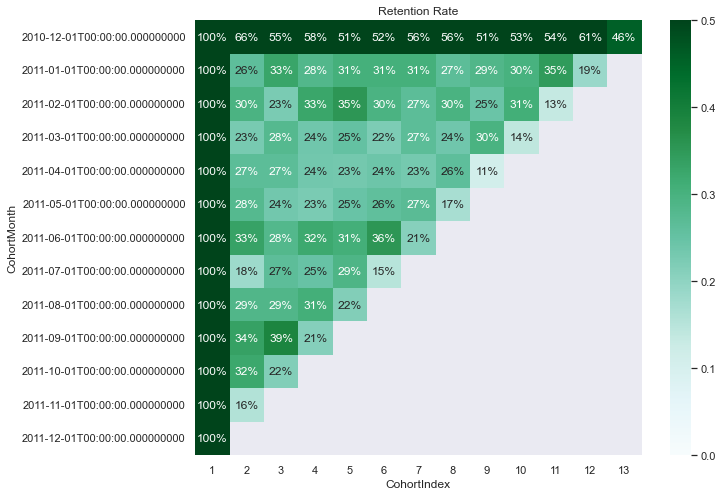

In [117]:
plt.figure(figsize=(10,8))
plt.title("Retention Rate")
sns.heatmap(data=retention,
           annot=True,
           fmt='.0%',
           vmin=0.0,
           vmax=0.5,
           cmap="BuGn")
plt.show()